In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002617FF42170>>
Traceback (most recent call last):
  File "C:\Users\91986\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [3]:
sdir = r"Processed Images_Fruits"
bad_path = r"Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"Processed Images_Fruits/Good Quality_Fruits"
mixed_path = r"Processed Images_Fruits/Mixed Qualit_Fruits"

filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

filepaths             labels
0      Processed Images_Fruits/Bad Quality_Fruits\App...          Apple_Bad
1      Processed Images_Fruits/Bad Quality_Fruits\App...          Apple_Bad
2      Processed Images_Fruits/Bad Quality_Fruits\App...          Apple_Bad
3      Processed Images_Fruits/Bad Quality_Fruits\App...          Apple_Bad
4      Processed Images_Fruits/Bad Quality_Fruits\App...          Apple_Bad
...                                                  ...                ...
19521  Processed Images_Fruits/Mixed Qualit_Fruits\Po...  Pomegranate_mixed
19522  Processed Images_Fruits/Mixed Qualit_Fruits\Po...  Pomegranate_mixed
19523  Processed Images_Fruits/Mixed Qualit_Fruits\Po...  Pomegranate_mixed
19524  Processed Images_Fruits/Mixed Qualit_Fruits\Po...  Pomegranate_mixed
19525  Processed Images_Fruits/Mixed Qualit_Fruits\Po...  Pomegranate_mixed

[19526 rows x 2 columns]

In [4]:
df['labels']=df['labels'].astype('category')

In [5]:
df['labels'].value_counts()


labels
Pomegranate_Good     5940
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df['labels'].unique()

['Apple_Bad', 'Banana_Bad', 'Guava_Bad', 'Lime_Bad', 'Orange_Bad', ..., 'Banana_mixed', 'Guava_mixed', 'Lemon_mixed', 'Orange_mixed', 'Pomegranate_mixed']
Length: 18
Categories (18, object): ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', ..., 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']

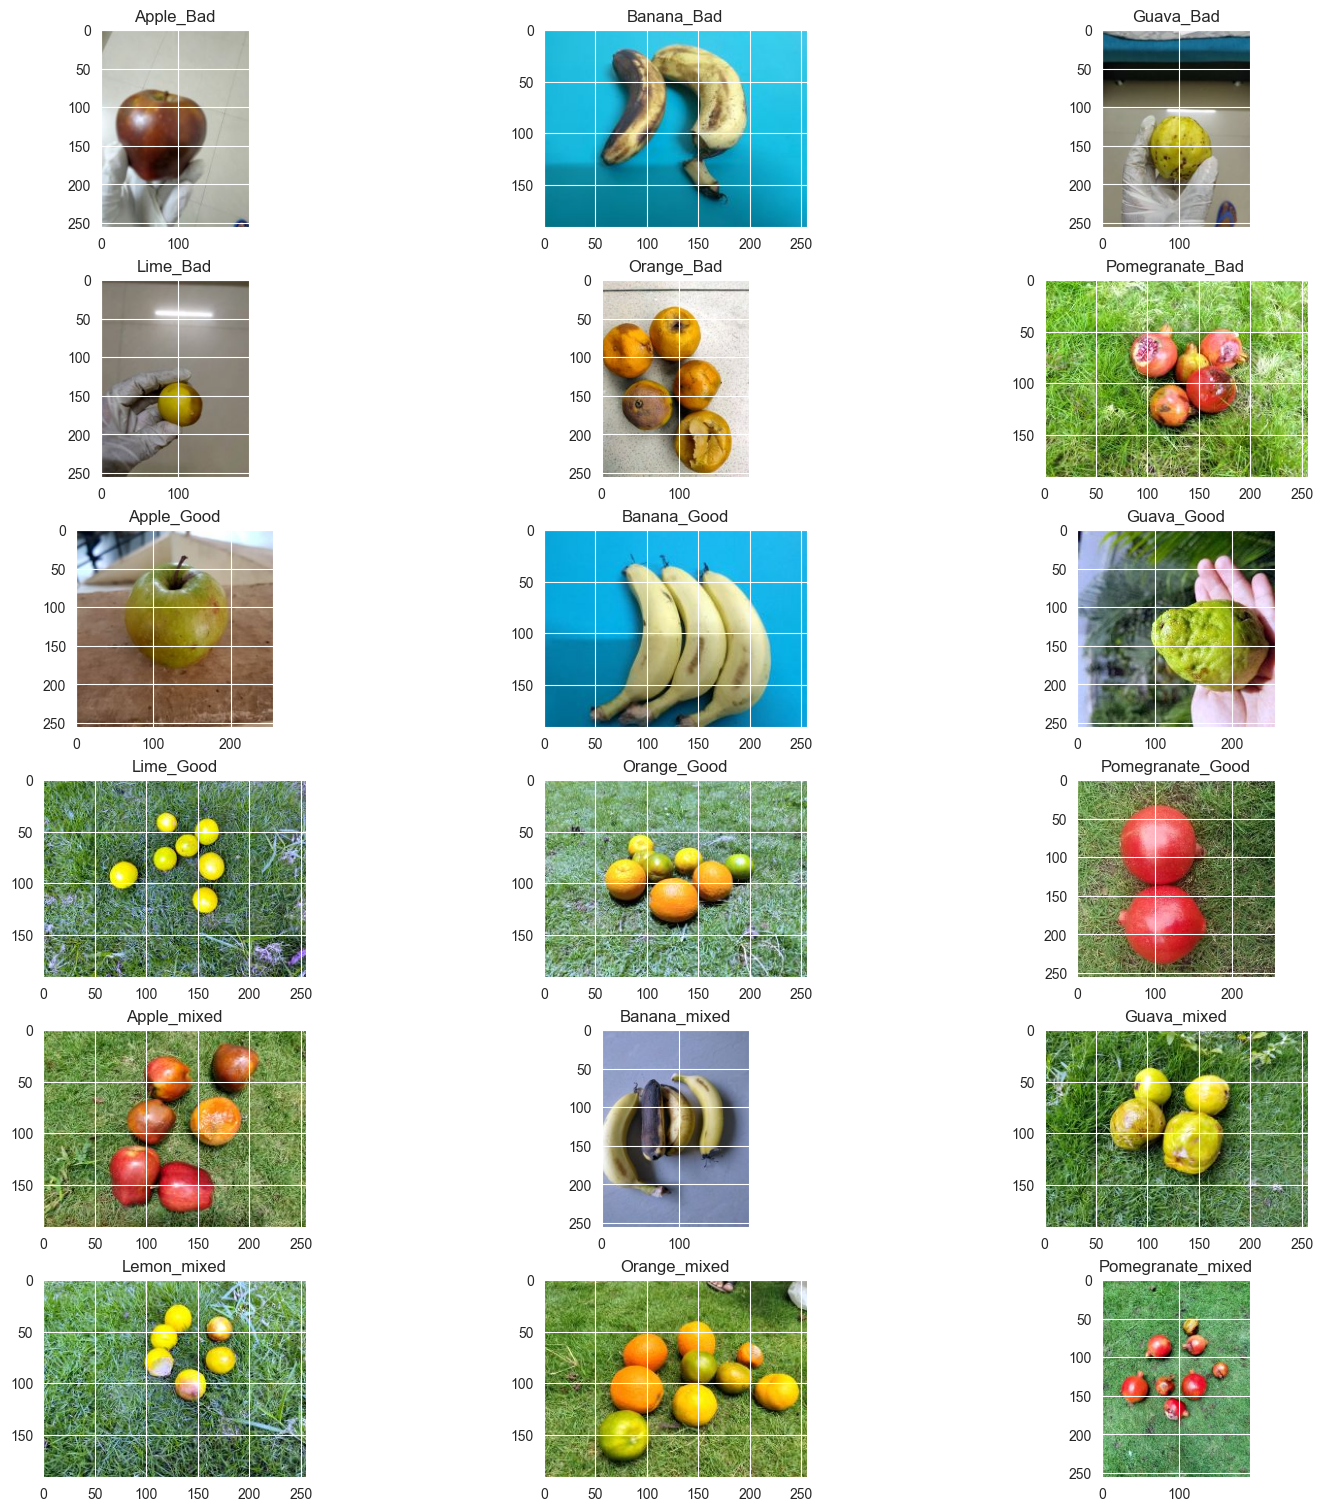

In [7]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15,15), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():
    
    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=123)

In [9]:
print(X_train.shape)
print(X_test.shape)

(15620, 2)
(3906, 2)


In [10]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                              validation_split=0.2)
testGen =ImageDataGenerator(preprocessing_function= preprocess_input)
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                           x_col='filepaths', 
                                           y_col='labels',
                                           class_mode='categorical', 
                                           subset='training', 
                                           batch_size=32)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                         x_col='filepaths', 
                                         y_col='labels',
                                         class_mode='categorical', 
                                         subset='validation',
                                         batch_size=32)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, 
                                        x_col='filepaths', 
                                        y_col='labels',
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        shuffle=False)

Found 12496 validated image filenames belonging to 18 classes.
Found 3124 validated image filenames belonging to 18 classes.
Found 3906 validated image filenames belonging to 18 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


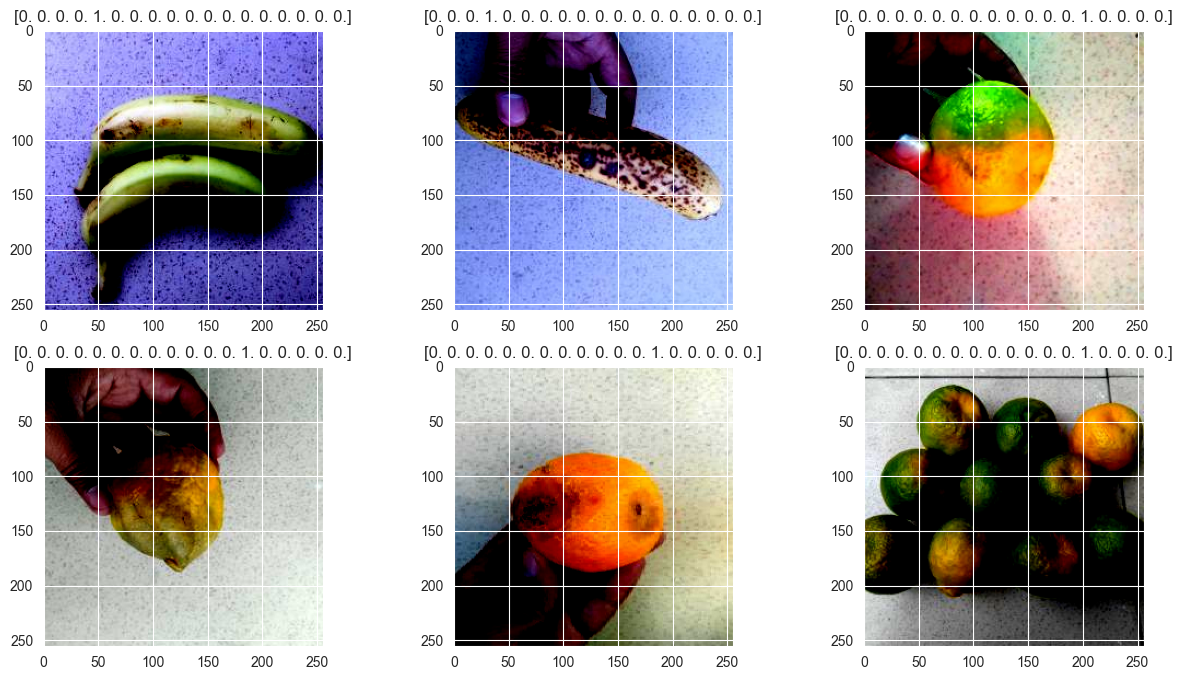

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))  # Create a 2x3 grid of subplots
ax = ax.flatten()  # Flatten the axes for easier iteration

for j in range(6):  # Loop through 6 times to display 6 images
    img, label = next(X_test_img)  # Use next() directly on the iterator
    ax[j].imshow(img[0],)  # Display the image
    ax[j].set_title(label[0])  # Set the title to the label
    #plt.show()
    j=j+1
   





In [11]:
X_test_img[0][0].shape

(32, 256, 256, 3)

In [12]:
image_shape=(256,256,3)

In [13]:
X_train_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [14]:
X_val_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
#Membuat base model dari pre-trained model dengan Inception ResNetV2
pre_trained= InceptionResNetV2(include_top=False, 
                               input_shape=image_shape)

#Freeze the convolutional base
pre_trained.trainable=False

inputs = pre_trained.input

x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(128, activation='relu')(x)
output=Dense(18, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)


#Compile the model
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,765,426 (208.91 MB)

 Trainable params: 428,690 (1.64 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

initial_epoch = 4
results = model.fit(X_train_img,epochs= initial_epoch,
                              validation_data=X_val_img,
                                callbacks=[early_stop])

Epoch 1/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 1943s 5s/step - accuracy: 0.5730 - loss: 1.5428 - val_accuracy: 0.8489 - val_loss: 0.5180
Epoch 2/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 1532s 4s/step - accuracy: 0.8391 - loss: 0.5295 - val_accuracy: 0.8960 - val_loss: 0.3452
Epoch 3/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 1467s 4s/step - accuracy: 0.8838 - loss: 0.3785 - val_accuracy: 0.9072 - val_loss: 0.2836
Epoch 4/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 1493s 4s/step - accuracy: 0.9118 - loss: 0.2883 - val_accuracy: 0.9273 - val_loss: 0.2328


Text(0.5, 1.0, 'Loss')

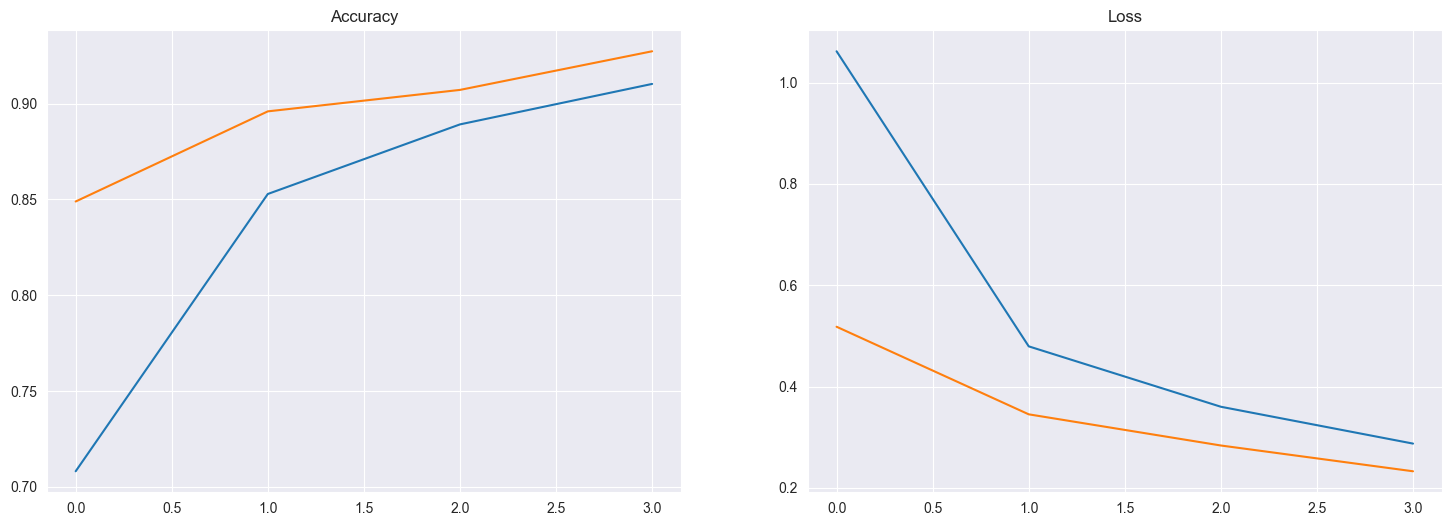

In [24]:
result_df = pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result_df[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss','val_loss']])
ax[1].set_title("Loss")

In [25]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step


In [38]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")


Accuracy Score: 0.9272913466461854


                                               filepaths            labels  \
8323   Processed Images_Fruits/Good Quality_Fruits\Ba...       Banana_Good   
4204   Processed Images_Fruits/Bad Quality_Fruits\Lim...          Lime_Bad   
16867  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
4413   Processed Images_Fruits/Bad Quality_Fruits\Lim...          Lime_Bad   
12590  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
14868  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   

                   pred  
8323        Banana_Good  
4204           Lime_Bad  
16867  Pomegranate_Good  
4413           Lime_Bad  
12590  Pomegranate_Good  
14868  Pomegranate_Good  


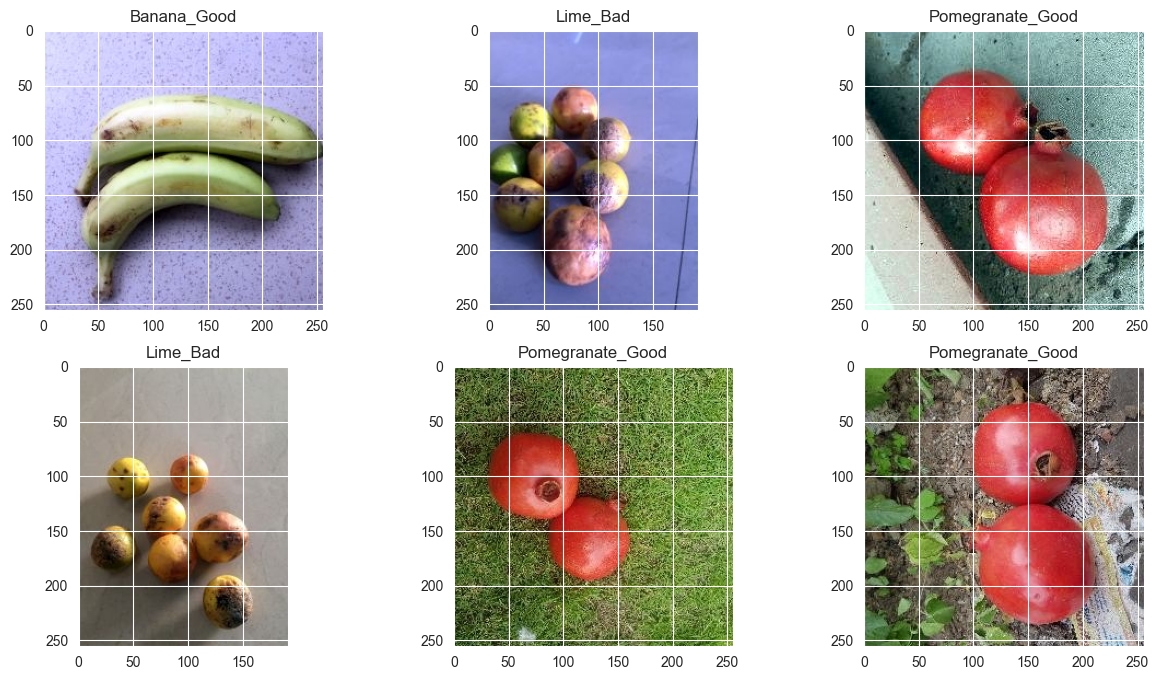

In [40]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

In [41]:
pre_trained.trainable = True

In [42]:
print("Number of layers in the base model: ", len(pre_trained.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,765,426 (208.91 MB)

 Trainable params: 53,937,314 (205.75 MB)

 Non-trainable params: 828,112 (3.16 MB)

In [45]:
len(model.trainable_variables)

430

In [46]:
fine_tune_epochs = 2
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(X_train_img,
                         epochs=total_epochs,
                         initial_epoch=10,
                         validation_data=X_val_img)

In [47]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

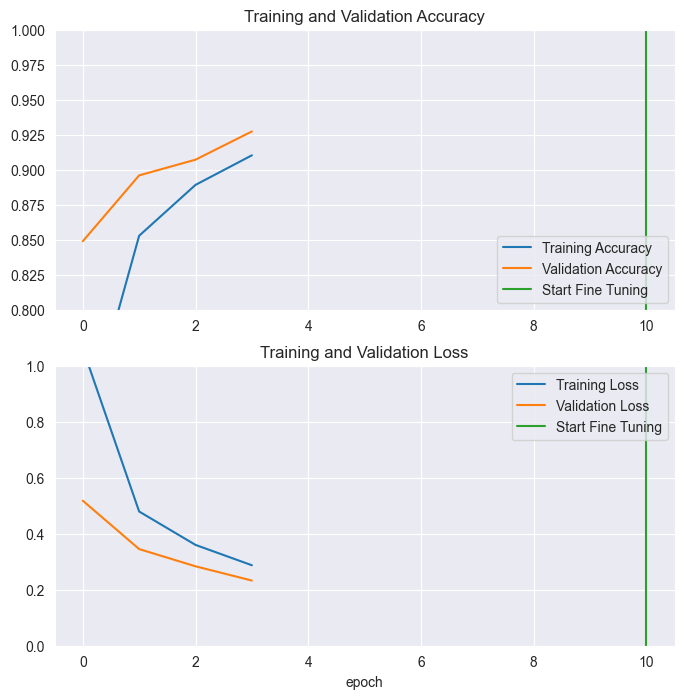

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [50]:
loss, accuracy = model.evaluate(X_test_img)
print('Test accuracy :', accuracy)

123/123 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9196 - loss: 0.2543
Test accuracy : 0.9272913336753845


In [51]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step


In [52]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")


Accuracy Score: 0.9272913466461854


In [55]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(20))
fig, ax=plt.subplots(nrows=4, ncols=5, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(20).reset_index()
for i in range(0,20):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

                                               filepaths            labels  \
8323   Processed Images_Fruits/Good Quality_Fruits\Ba...       Banana_Good   
4204   Processed Images_Fruits/Bad Quality_Fruits\Lim...          Lime_Bad   
16867  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
4413   Processed Images_Fruits/Bad Quality_Fruits\Lim...          Lime_Bad   
12590  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
14868  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
12894  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
4928   Processed Images_Fruits/Bad Quality_Fruits\Ora...        Orange_Bad   
2547   Processed Images_Fruits/Bad Quality_Fruits\Gua...         Guava_Bad   
6524   Processed Images_Fruits/Bad Quality_Fruits\Pom...   Pomegranate_Bad   
16789  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegranate_Good   
14233  Processed Images_Fruits/Good Quality_Fruits\Po...  Pomegr

In [60]:
model.save("model_fruitNet.keras")



In [62]:
import tensorflow as tf

# Convert the Keras model to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model as a .tflite file
with open('model_fruitNet.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite and saved as 'model_fruitNet.tflite'")


Saved artifact at 'C:\Users\mayan\AppData\Local\Temp\tmpyx98_uoe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_790')
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  2031384479696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384481280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384491488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384492192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384483920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384488848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031380139168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031384480752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031380145856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031380149904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [5]:
#import tensorflow as tf
import numpy as np
from PIL import Image

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model_fruitNet.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Check the input shape of the model
print("Model input shape:", input_details[0]['shape'])

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image to the target input size of the model
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img, dtype=np.float32)
    # Normalize the image (if your model was trained with normalized inputs)
    img_array /= 255.0
    # Expand dimensions to match the model's input shape (e.g., [1, height, width, 3])
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the input image (replace with your image path)
image_path = 'Processed Images_Fruits\\Bad Quality_Fruits\\Banana_Bad\\IMG_7693.JPG'  # Example: 'test_image.jpg'

# Get the correct input shape from the model
input_shape = input_details[0]['shape']  # e.g., [1, 256, 256, 3]

# Preprocess the input image to match the model's input size
input_image = preprocess_image(image_path, target_size=(input_shape[1], input_shape[2]))  # Using model's expected height and width

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process the output (for classification tasks, use argmax)
predicted_class = np.argmax(output_data)

print("Predicted class:", predicted_class)



Model input shape: [  1 256 256   3]
Predicted class: 3


In [8]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained classification model
model = load_model('model_fruitNet.keras')

# Load the YOLO model for object detection
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")  # Replace with YOLO paths
layer_names = net.getLayerNames()

# Adjust this line to fix the index issue
try:
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
except TypeError:
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Function to preprocess image (adjust based on your model's input requirements)
def preprocess_image(image):
    image = cv2.resize(image, (256, 256))  # resize image to match model input
    image = image.astype('float32') / 255.0  # normalize
    image = np.expand_dims(image, axis=0)  # add batch dimension
    return image

# Function to predict class
def predict_class(image):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    class_label = np.argmax(prediction)  # get the class label
    return class_label

# Function to perform object detection and get bounding boxes for fruits
def detect_fruits(frame):
    height, width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)
    boxes = []
    
    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            # Assuming class_id matches with a fruit class from YOLO model
            if confidence > 0.5 and class_id == 53:  # Use appropriate fruit class id
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                w = int(obj[2] * width)
                h = int(obj[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append((x, y, w, h))
    
    return boxes

# Open a connection to the camera
cap = cv2.VideoCapture(0)  # 0 for the default camera

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    # Detect fruits in the frame
    fruit_boxes = detect_fruits(frame)
    
    # Check if any fruits are detected
    if fruit_boxes:
        for (x, y, w, h) in fruit_boxes:
            fruit = frame[y:y+h, x:x+w]  # Crop the fruit area
            predicted_class = predict_class(fruit)

            # Draw bounding box and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, f'Predicted Class: {predicted_class}', (x, y-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    else:
        # No fruits detected, display "None"
        cv2.putText(frame, 'Predicted Class: None', (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display the resulting frame with detection and prediction
    cv2.imshow('Fruit Detection and Classification', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture when done
cap.release()
cv2.destroyAllWindows()
